# Transfer Learning Experiment with augmentation with 5 class

## Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Libraries

In [2]:
import datetime
import operator
##open cv
import cv2
from google.colab.patches import cv2_imshow
import random
#numpy-pandas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow and utilities
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers

#tensorflow model, layers, optimizers etc
from tensorflow.keras import Input 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, concatenate, AveragePooling2D, GlobalAveragePooling2D

#callbacks
from tensorflow.keras.callbacks import BaseLogger, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ReduceLROnPlateau

#pretrained models
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score

#Loading TensorBoard
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

## 2. Import Data

In [3]:
#getting dataframes of train and test data
train_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_test_df.csv")

#setting up path
train_df["path"] = train_df["class"] + "/" + train_df["image_name"]
test_df["path"] = test_df["class"] + "/" + test_df["image_name"]

#getting shape
print("Shape of train dataset is {}.".format(train_df.shape))
print("Shape of test dataset is {}.".format(test_df.shape))

Shape of train dataset is (14523, 4).
Shape of test dataset is (3527, 4).


In [4]:
train_df["class"].value_counts()

Seborrheic Keratoses and other Benign Tumors                          1350
Psoriasis pictures Lichen Planus and related diseases                 1297
Eczema Photos                                                         1222
Tinea Ringworm Candidiasis and other Fungal Infections                1218
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    1118
Warts Molluscum and other Viral Infections                             985
Nail Fungus and other Nail Disease                                     855
Systemic Disease                                                       568
Acne and Rosacea Photos                                                561
Light Diseases and Disorders of Pigmentation                           546
Atopic Dermatitis Photos                                               485
Vascular Tumors                                                        482
Melanoma Skin Cancer Nevi and Moles                                    456
Bullous Disease Photos   

In [5]:
test_df["class"].value_counts()

Seborrheic Keratoses and other Benign Tumors                          339
Psoriasis pictures Lichen Planus and related diseases                 339
Tinea Ringworm Candidiasis and other Fungal Infections                309
Eczema Photos                                                         300
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    283
Warts Molluscum and other Viral Infections                            247
Nail Fungus and other Nail Disease                                    210
Systemic Disease                                                      143
Light Diseases and Disorders of Pigmentation                          137
Vascular Tumors                                                       121
Atopic Dermatitis Photos                                              120
Melanoma Skin Cancer Nevi and Moles                                   115
Bullous Disease Photos                                                113
Vasculitis Photos                     

## 3. Class Selection

In [6]:
class_to_keep = ["Herpes HPV and other STDs Photos", "Melanoma Skin Cancer Nevi and Moles", 
                 "Hair Loss Photos Alopecia and other Hair Diseases", "Urticaria Hives"]
                 
train_df_m1 = train_df[train_df["class"].isin(class_to_keep)]
test_df_m1 = test_df[test_df["class"].isin(class_to_keep)]

#getting only 500 images of nail fungus
train_df_m2 = train_df[train_df["class"] == "Nail Fungus and other Nail Disease"].iloc[0:500,:]
test_df_m2 = test_df[test_df["class"] == "Nail Fungus and other Nail Disease"].iloc[0:500,:]

merged_train_df = pd.concat([train_df_m1, train_df_m2])
merged_test_df = pd.concat([test_df_m1, test_df_m2])

#getting the values counts
merged_train_df["class"].value_counts()

Nail Fungus and other Nail Disease                   500
Melanoma Skin Cancer Nevi and Moles                  456
Herpes HPV and other STDs Photos                     382
Urticaria Hives                                      212
Hair Loss Photos Alopecia and other Hair Diseases    212
Name: class, dtype: int64

In [7]:
train_df_final, validation_df_final = train_test_split(merged_train_df, test_size=0.20)
print("Shape of train : {}.".format(train_df_final.shape))
print("Shape of test : {}.".format(validation_df_final.shape))

Shape of train : (1409, 4).
Shape of test : (353, 4).


In [8]:
merged_test_df["class_cat"] = merged_test_df["class"].astype('category').cat.codes
y_true = merged_test_df["class_cat"].values

## 4. Data Pipeline

In [9]:
channels = 3
batchsize = 32
num_classes = 5
img_rows = 256
img_cols = 256 

In [10]:
#datagwn without augmentation
datagen_aug = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.3,
                                 width_shift_range=0.4,
                                 horizontal_flip=True,
                                 brightness_range=(0.2,0.5),
                                 fill_mode='nearest')

#Train Generator
train_gen_aug = datagen_aug.flow_from_dataframe(dataframe = train_df_final, 
                                        directory="/content/drive/MyDrive/Dermnet/Images/train/", x_col="path", y_col="class", 
                                        class_mode="categorical", subset="training", shuffle=True,
                                        target_size=(img_rows, img_cols), 
                                        batch_size = batchsize, 
                                        color_mode='rgb',
                                        seed=42)

#Validation Generator
valid_gen_aug = datagen_aug.flow_from_dataframe(dataframe = validation_df_final, 
                                        directory="/content/drive/MyDrive/Dermnet/Images/train/", x_col="path", y_col="class", 
                                        class_mode="categorical", subset="training", shuffle=True,
                                        target_size=(img_rows, img_cols), 
                                        batch_size = batchsize, 
                                        color_mode='rgb',
                                        seed=42)

Found 1409 validated image filenames belonging to 5 classes.
Found 353 validated image filenames belonging to 5 classes.


## 5. Callbacks

In [11]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
#reduce learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.001)

## 6. Plot Functions

In [ ]:
def loss_plot(train_loss, test_loss, total_epoch):
    """
    This function plots the loss graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(15,5))  #setting up figure size
    plt.plot(train_loss);  plt.plot(test_loss)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Loss", "Validation_Loss"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Log Loss", fontsize=10)
    plt.title("Loss Plot for train and validation dataset", fontsize=20)
    return plt.show()



def accuracy_plot(train_accuracy, test_accuracy, total_epoch):
    """
    This function plots the accuracy graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(15,5))  #setting up figure size
    plt.plot(train_accuracy);  plt.plot(test_accuracy)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Accuracy", "Validation_Accuracy"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Plot for train and validation dataset", fontsize=20)
    return plt.show()


## 7. VGG16 - Transfer Learning - with Augmenation

In [ ]:
def transfer_learning_VGG16(img_rows, img_cols, channels, nb_train_samples, num_classes):

    """
    This is a pre trained VGG16 model.
    input:
    ------
        img_rows           : width of the image
        img_cols           : height of the image
        channels           : rgb(3), grayscale(1)
        nb_train_samples   : number of training samples
        num_classes        : number of classes to be trained
    output:
    -------
        model setup
    """

    #Load Pre-trained VGG Model with weight initialized from imagenet and input as given
    model_vgg = VGG16(include_top=False, weights="imagenet", input_shape=(img_rows, img_cols, channels))
    # mark loaded layers as not trainable
    for layer in model_vgg.layers:
        layer.trainable = False
    #Flatten
    flat_layer = Flatten(data_format='channels_last',name='Flatten')(model_vgg.layers[-1].output)
    dense_layer1 = Dense(units=nb_train_samples, activation='relu', 
                        kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        name='FC1')(flat_layer)
    dense_layer2 = Dense(units=nb_train_samples, activation='relu', 
                        kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        name='FC2')(dense_layer1)
    drop = Dropout(0.2)
    output = Dense(units=num_classes, activation='softmax', 
                   kernel_initializer=tf.keras.initializers.glorot_normal(seed=3), 
                   name='Output')(dense_layer2)
    #Creating a model
    model = Model(inputs = model_vgg.inputs, outputs = output)

    return model

In [ ]:
epochs= 30
nb_train_samples = 1409
nb_validation_samples = 353

In [ ]:
#function call
model = transfer_learning_VGG16(img_rows, img_cols, channels, nb_train_samples, num_classes)

#compilation of model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

58892288/58889256 [==============================] - 0s 0us/step


## 8. Training the Model

In [ ]:
# fitting model
history = model.fit(train_gen_aug, steps_per_epoch = nb_train_samples//batchsize, epochs=epochs, 
                    validation_data=valid_gen_aug,
                    validation_steps=nb_validation_samples//batchsize,
                    callbacks = [earlyStopping, reduceLR])

Epoch 1/30
44/44 [==============================] - 1032s 23s/step - loss: 5.2057 - accuracy: 0.3458 - val_loss: 3.9068 - val_accuracy: 0.5028
Epoch 2/30
44/44 [==============================] - 38s 876ms/step - loss: 3.6444 - accuracy: 0.4974 - val_loss: 3.0812 - val_accuracy: 0.4886
Epoch 3/30
44/44 [==============================] - 38s 867ms/step - loss: 2.8516 - accuracy: 0.5433 - val_loss: 2.7438 - val_accuracy: 0.4034
Epoch 4/30
44/44 [==============================] - 38s 874ms/step - loss: 2.5001 - accuracy: 0.5099 - val_loss: 2.4354 - val_accuracy: 0.4801
Epoch 5/30
44/44 [==============================] - 39s 894ms/step - loss: 2.4979 - accuracy: 0.4871 - val_loss: 2.3044 - val_accuracy: 0.5568
Epoch 6/30
44/44 [==============================] - 38s 875ms/step - loss: 2.1818 - accuracy: 0.5827 - val_loss: 2.2233 - val_accuracy: 0.5312
Epoch 7/30
44/44 [==============================] - 39s 881ms/step - loss: 2.0574 - accuracy: 0.6031 - val_loss: 1.9528 - val_accuracy: 0.6136

## 9 .Save Model

In [ ]:
# creates a HDF5 file
model.save('/content/drive/MyDrive/Dermnet/SavedModels/expeiment8.h5')

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

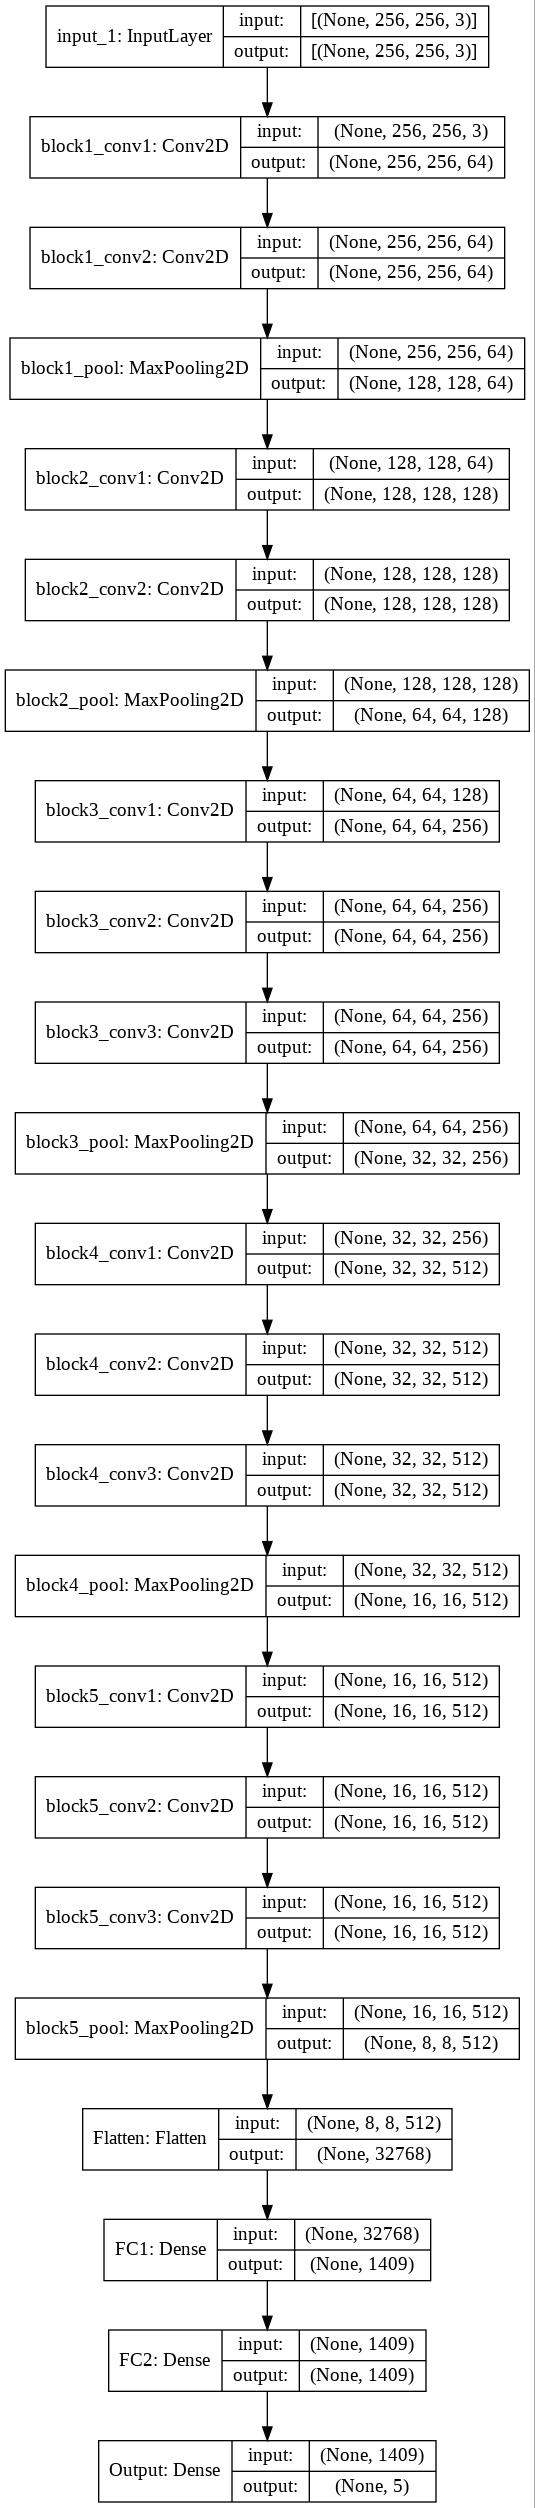

In [ ]:
tf.keras.utils.plot_model(model, to_file="experiment8.jpg", show_shapes=True)

## 10. Loss and Accuracy Plot

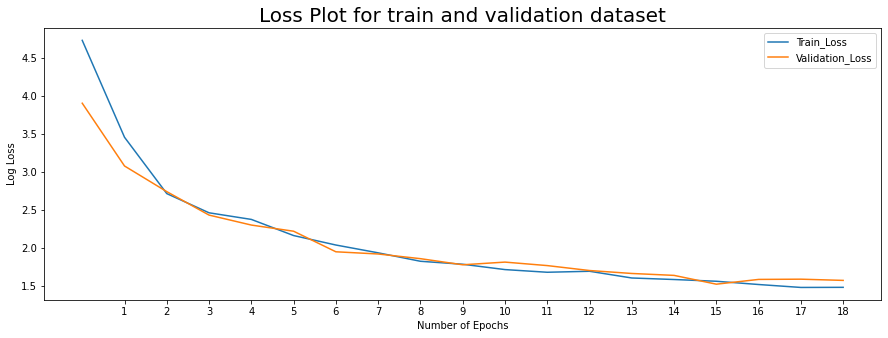

In [ ]:
loss_plot(history.history["loss"], history.history["val_loss"], 19)

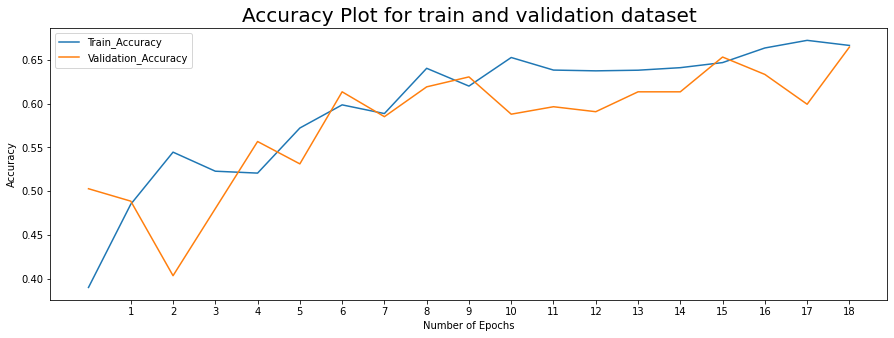

In [ ]:
accuracy_plot(history.history["accuracy"], history.history["val_accuracy"], 19)

## 11. Prediction 

In [12]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Dermnet/SavedModels/expeiment8.h5')

In [13]:
#Validation Generator
test_generator = datagen_aug.flow_from_dataframe(dataframe = merged_test_df, 
                                            directory="/content/drive/MyDrive/Dermnet/Images/test/", 
                                            x_col="path", 
                                            y_col=None, 
                                            class_mode=None,
                                            subset=None,
                                            shuffle=False,
                                            target_size=(img_rows, img_cols),
                                            batch_size = batchsize,
                                            color_mode='rgb')

Found 510 validated image filenames.


In [14]:
#predicting all values
output_scores = model.predict_generator(test_generator)

## 12. Evaluation Metric

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
#getting output scores
class_outputs = [max(enumerate(val), key=operator.itemgetter(1)) for val in output_scores]
#getting prediction values
y_pred = [val[0] for val in class_outputs]


#getting confusion metrix
conf_matrix = confusion_matrix(y_true, y_pred)


#getting classification report 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55        46
           1       0.69      0.43      0.53        86
           2       0.57      0.62      0.59       115
           3       0.92      0.86      0.89       210
           4       0.42      0.66      0.51        53

    accuracy                           0.69       510
   macro avg       0.62      0.63      0.62       510
weighted avg       0.71      0.69      0.69       510



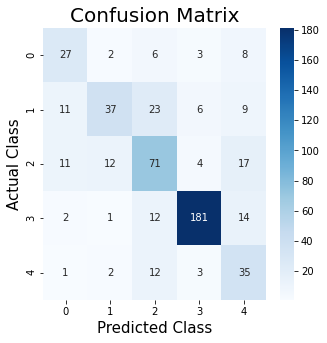

In [17]:
fig = plt.figure(figsize=(5,5))
plot = sns.heatmap(conf_matrix, annot=True, cmap ="Blues", fmt="d")
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Actual Class", fontsize=15)
plt.title("Confusion Matrix", fontsize=20)
plt.show()

In [18]:
## accuracy scores
print("Accuracy Score        {:.4f}.".format(accuracy_score(y_true,y_pred)))
print("Overall f1 score      {:.4f}.".format(f1_score(y_true, y_pred, average='micro')))
print("Overall Precision     {:.4f}.".format(precision_score(y_true, y_pred, average='micro')))
print("Overall Recall        {:.4f}.".format(recall_score(y_true, y_pred, average='micro')))

Accuracy Score        0.6882.
Overall f1 score      0.6882.
Overall Precision     0.6882.
Overall Recall        0.6882.
